### The general task for this assignment is to build two different models for detecting spam messages (based on the email characteristics that are given): (i) the best possible model that you can build in terms of the overall predictive accuracy (i.e., not taking any cost information into account), and (ii) the best cost-sensitive classification model that you can build in terms of the average misclassification cost.

In [2]:
#Import statements
import pandas as pd
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline.
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd
import math
import numpy as np

import scikitplot as skplt
from sklearn import tree, neighbors, linear_model, preprocessing
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve, precision_recall_fscore_support, mean_squared_error


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import recall_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

#### Import Dataset

In [3]:
df = pd.read_csv('spambase.data', header = None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


#### Identifying class label column

In [3]:
df.nunique()
df[57].unique()
# The last column is our label since it is the only column with unique 0/1 values.

array([1, 0], dtype=int64)

#### Train test split

In [4]:
X = df.drop([57], axis=1)
y = df[57]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Part A

#### Initializing models, defining parameters for models and building pipelines

In [13]:
# Grid search
inner_cv = KFold(n_splits=4, shuffle= True, random_state = 30)
outer_cv = KFold(n_splits=4, shuffle = True, random_state = 30)
scoring = 'balanced_accuracy'

#Initializing models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression()
svm = SVC(max_iter = 100, probability = True)


el = ElasticNet(random_state=0)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(verbose_eval=False)

# Pipelines
lr_pl = Pipeline([('sc', StandardScaler()), ('lr', lr)])
knn_pl = Pipeline([('sc', StandardScaler()), ('knn', knn)])
svm_pl = Pipeline([('sc', StandardScaler()), ('svm', svm)])

# Defining model parameters
el_a = [.1, .5, .7, .9, .95, .99, 1]
knn_grid = {'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
knn_grid_1 = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
dt_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}

c_val = np.logspace(-5, 5, 11)
lr_grid = {'lr__C': c_val}
lr_grid_1 = {'C': c_val}
svm_grid = {"svm__C": c_val, "svm__gamma": c_val}

rf_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
xgb_grid = {'n_estimators': [100,200,300,400,500],'max_depth': [1,2,3,4,5,6,7,8,9,10], 
           'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}

##################### NEURAL NETWORK ###########
num_classes = 2 # class size
input_unit_size = 57 # input vector size

# Model Structure definiton
def build_model():
    model = Sequential()
    model.add(Dense(50, input_dim=input_unit_size, activation='relu'))
    model.add(Dense(20, input_dim=input_unit_size, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

batch_size = [5, 10, 20, 25, 30]
epoch = [5, 10]
nn_grid = dict(epochs=epoch, batch_size=batch_size)

#### k-NN (without normalization)

In [12]:
knn_clf = GridSearchCV(estimator = knn, scoring = scoring, param_grid = knn_grid_1,  cv = inner_cv)
knn_score = cross_val_score(knn_clf, X=X_train, y=y_train, cv = outer_cv)
knn_score_mean = knn_score.mean()
print('KNN (without Normalization) Accuracy: ', knn_score_mean)

KNN (without Normalization) Accuracy:  0.7888623846395293


#### k-NN

In [7]:
knn_clf = GridSearchCV(estimator = knn_pl, scoring = scoring, param_grid = knn_grid,  cv = inner_cv)
knn_score = cross_val_score(knn_clf, X=X_train, y=y_train, cv = outer_cv)
knn_score_mean = knn_score.mean()
print('KNN Accuracy: ', knn_score_mean)

KNN Accuracy:  0.8870852337004282


#### Decision Tree

In [8]:
dt_clf = GridSearchCV(estimator = dt, scoring = scoring, param_grid = dt_grid, cv = inner_cv)
dt_score = cross_val_score(dt_clf, X=X_train, y=y_train, cv = outer_cv)
dt_score_mean = dt_score.mean()
print('Decision Tree Accuracy: ', dt_score_mean)


Decision Tree Accuracy:  0.9038410838646154


#### Logistic Regression (without Normalization)

In [15]:
lr_clf = GridSearchCV(estimator = lr, param_grid = lr_grid_1, scoring = scoring, cv = inner_cv)
lr_score = cross_val_score(lr_clf, X=X_train, y=y_train, cv = outer_cv)
lr_score_mean = lr_score.mean()
print('Logistic (without Normalization) Regression Accuracy: ', lr_score_mean)


Logistic (without Normalization) Regression Accuracy:  0.908354359879099


#### Logistic Regression

In [10]:
lr_clf = GridSearchCV(estimator = lr_pl, param_grid = lr_grid, scoring = scoring, cv = inner_cv)
lr_score = cross_val_score(lr_clf, X=X_train, y=y_train, cv = outer_cv)
lr_score_mean = lr_score.mean()
print('Logistic Regression Accuracy: ', lr_score_mean)


Logistic Regression Accuracy:  0.9155354211739641


#### Support Vector Machine

In [11]:
svm_clf = GridSearchCV(estimator = svm_pl, param_grid = svm_grid, scoring = scoring, cv = inner_cv)
svm_score = cross_val_score(svm_clf, X=X_train, y=y_train, cv = outer_cv)
svm_score_mean = svm_score.mean()
print('SVM Accuracy: ', svm_score_mean)

SVM Accuracy:  0.753407806594439


#### Random Forest

In [12]:
rf_clf = GridSearchCV(estimator = rf, scoring = scoring, param_grid = rf_grid, cv = inner_cv)
rf_score = cross_val_score(rf_clf, X=X_train, y=y_train, cv = outer_cv)
rf_score_mean = rf_score.mean()
print(rf_score_mean)

0.9322887857822949


#### Neural Networks

In [13]:
len(X.columns)
# Since we have 57 columns, the input vector size is 57.

57

In [9]:
model1 = KerasClassifier(build_fn = build_model, verbose=0)

nn = GridSearchCV(estimator = model1, param_grid = nn_grid, cv=inner_cv, scoring = scoring)
nn_score = cross_val_score(nn, X=X_train, y=y_train, cv=outer_cv, scoring = scoring)
nn_score_mean = nn_score.mean()
print(nn_score_mean)


0.8723192136227526


### Comparing the accuracy scores for the models we have run, we choose Random Forest as our final model as it has the best accuracy. 

In [37]:
rf_fin = RandomForestClassifier(random_state=0)
rf_f = GridSearchCV(estimator = rf_fin, scoring = scoring, param_grid = rf_grid, cv = inner_cv)
y_pred = rf_f.fit(X=X_train, y=y_train).predict(X_test)

print(rf_f.best_params_)
print(accuracy_score(y_pred, y_test))


{'max_depth': 10, 'min_samples_leaf': 1}
0.9381107491856677


In [40]:
print(accuracy_score(y_pred, y_test))
print('Recall for class 1', recall_score(y_test, y_pred))
print('Recall for class 0',recall_score(y_test, y_pred, pos_label = 0))
print('Precision for class 1',precision_score(y_test, y_pred))
print('Precision for class 0', precision_score(y_test, y_pred, pos_label = 0))
print('F1 Score for class 1', f1_score(y_test, y_pred))
print('F1 Score for class 0', f1_score(y_test, y_pred, pos_label = 0))

0.9381107491856677
Recall for class 1 0.8871794871794871
Recall for class 0 0.975517890772128
Precision for class 1 0.9637883008356546
Precision for class 0 0.9217081850533808
F1 Score for class 1 0.9238985313751668
F1 Score for class 0 0.9478499542543458


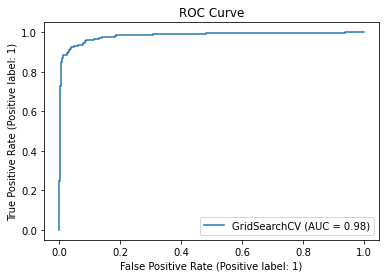

In [17]:
plot_roc_curve(rf_f, X_test, y_test) 
plt.title('ROC Curve')
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

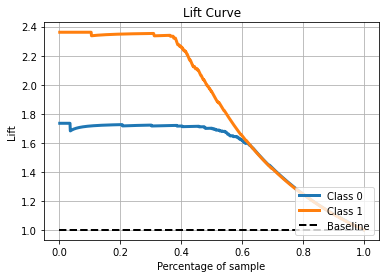

In [18]:
y_probas = rf_f.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas)


### Part B

#### Initializing models with class weights 10:1, building pipelines. 

In [35]:
#custom_scorer = make_scorer(recall_score, greater_is_better=True,  pos_label=0)

scoring = 'balanced_accuracy'

#Initializing models

dt = DecisionTreeClassifier(class_weight  = {0:10, 1:1})
lr = LogisticRegression(class_weight  = {0:10, 1:1})
svm = SVC(max_iter = 100, probability = True, class_weight  = {0:10, 1:1})

rf = RandomForestClassifier(random_state=0, class_weight  = {0:10, 1:1})

model1 = KerasClassifier(build_fn = build_model, verbose=0, class_weight  = {0:10, 1:1})

# Pipelines
lr_pl = Pipeline([('sc', StandardScaler()), ('lr', lr)])
svm_pl = Pipeline([('sc', StandardScaler()), ('svm', svm)])
nn_pl = Pipeline([('sc', StandardScaler()), ('model1', svm)])

#### k-NN

In [23]:
knn_clf = GridSearchCV(estimator = knn_pl, scoring = scoring, param_grid = knn_grid,  cv = inner_cv)
knn_score = cross_val_score(knn_clf, X=X_train, y=y_train, cv = outer_cv)
knn_score_mean = knn_score.mean()
print('KNN Accuracy: ', knn_score_mean)

KNN Accuracy:  0.8870852337004282


#### Decision tree

In [24]:
dt_clf = GridSearchCV(estimator = dt, scoring = scoring, param_grid = dt_grid, cv = inner_cv)
dt_score = cross_val_score(dt_clf, X=X_train, y=y_train, cv = outer_cv)
dt_score_mean = dt_score.mean()
print('Decision Tree Accuracy: ', dt_score_mean)

Decision Tree Accuracy:  0.8742758414702734


#### Logistic Regression

In [25]:
lr_clf = GridSearchCV(estimator = lr_pl, param_grid = lr_grid, scoring = scoring, cv = inner_cv)
lr_score = cross_val_score(lr_clf, X=X_train, y=y_train, cv = outer_cv)
lr_score_mean = lr_score.mean()
print('Logistic Regression Accuracy: ', lr_score_mean)

Logistic Regression Accuracy:  0.8023669280488241


#### Support Vector Machine

In [26]:
svm_clf = GridSearchCV(estimator = svm_pl, param_grid = svm_grid, scoring = scoring, cv = inner_cv)
svm_score = cross_val_score(svm_clf, X=X_train, y=y_train, cv = outer_cv)
svm_score_mean = svm_score.mean()
print('SVM Accuracy: ', svm_score_mean)

SVM Accuracy:  0.6333387087562352


#### Random Forest

In [27]:
rf_clf = GridSearchCV(estimator = rf, scoring = scoring, param_grid = rf_grid, cv = inner_cv)
rf_score = cross_val_score(rf_clf, X=X_train, y=y_train, cv = outer_cv)
rf_score_mean = rf_score.mean()
print('Random Forest Accuracy: ', rf_score_mean)

Random Forest Accuracy:  0.8896429025853901


#### Neural Network

In [28]:
model1 = KerasClassifier(build_fn = build_model, verbose=0)

nn = GridSearchCV(estimator = model1, param_grid = nn_grid, cv=inner_cv, scoring = scoring)
nn_score = cross_val_score(nn, X=X_train, y=y_train, cv=outer_cv, scoring = scoring)
nn_score_mean = nn_score.mean()
print('Neural Network Accuracy: ', nn_score_mean)


Neural Network Accuracy:  0.8398342911440314


#### Comparing the accuracy scores for the models run, Random Forest gives the best accuracy score. Thus, we choose it as our final model.

In [36]:
rf_cw = RandomForestClassifier(random_state=0, class_weight  = {0:10, 1:1})

rf_f1 = GridSearchCV(estimator = rf_cw, scoring = scoring, param_grid = rf_grid, cv = inner_cv)
y_pred1 = rf_f1.fit(X=X_train, y=y_train).predict(X_test)

print(rf_f1.best_params_)
print(accuracy_score(y_pred1, y_test))


{'max_depth': 10, 'min_samples_leaf': 1}
0.8859934853420195


In [41]:
print('Recall for class 1', recall_score(y_test, y_pred1))
print('Recall for class 0',recall_score(y_test, y_pred1, pos_label = 0))
print('Precision for class 1',precision_score(y_test, y_pred1))
print('Precision for class 0', precision_score(y_test, y_pred1, pos_label = 0))
print('F1 Score for class 1', f1_score(y_test, y_pred1))
print('F1 Score for class 0', f1_score(y_test, y_pred1, pos_label = 0))

Recall for class 1 0.7487179487179487
Recall for class 0 0.9868173258003766
Precision for class 1 0.9765886287625418
Precision for class 0 0.842443729903537
F1 Score for class 1 0.8476052249637155
F1 Score for class 0 0.9089332176929747


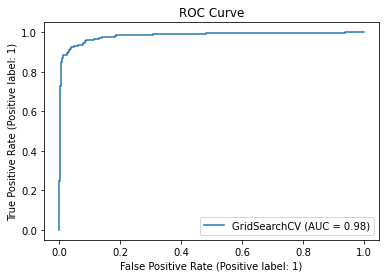

In [31]:
plot_roc_curve(rf_f, X_test, y_test) 
plt.title('ROC Curve')
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

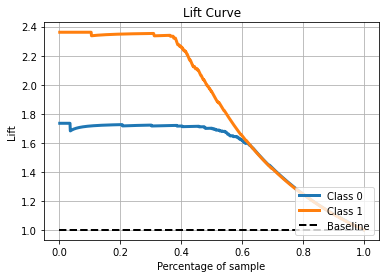

In [32]:
y_probas = rf_f.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas)


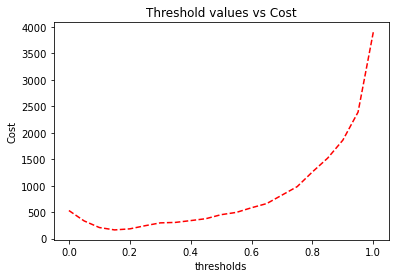

In [33]:
y_probas_1 = rf_f.predict_proba(X_test)[:,1]

threshold = np.linspace(0, 1.0, num=21)
cost = np.linspace(0, 1.0, num=21)

cost_matrix = np.array([[0, 1], 
                        [10, 0]])
index=0
for t in threshold:
   predict_thre = np.where(y_probas_1 > t, 1, 0) 
   clf_matrix = confusion_matrix(y_test, predict_thre)
   cost[index] = clf_matrix[0][0]*cost_matrix[0][0]+clf_matrix[0][1]*cost_matrix[0][1]+clf_matrix[1][0]*cost_matrix[1][0]+clf_matrix[1][1]*cost_matrix[1][1]
   index+=1
plt.figure(1)
plt.plot(threshold, cost, 'r--')
plt.title('Threshold values vs Cost')
plt.xlabel("thresholds")
plt.ylabel("Cost")
plt.show()

### Looking at the above chart, we can conclude that to get the lowest misclassfication cost, we should set the threshold value  ~0.18.

In [42]:
predict_thre = np.where(y_probas_1 > 0.18, 1, 0) 
clf_matrix = confusion_matrix(y_test, predict_thre)
cost_final = clf_matrix[0][0]*cost_matrix[0][0]+clf_matrix[0][1]*cost_matrix[0][1]+clf_matrix[1][0]*cost_matrix[1][0]+clf_matrix[1][1]*cost_matrix[1][1]
print(cost_final)

171


## Final Conclusions 

#### After importing the data, I identified the label column by finding the number of unique values in each column. The label column was the only column with two unique values of 1 & 0 in it (binary classification problem).

#### To measure the impact of normalization on the outcome of the model, I ran k-nn and logistic regression with and without normalization. In k-nn, there is a significant increase in the accuracy values when running without normalization (Accuracy: 0.78) vs when running with normalization (Accuracy: 0.88). For logistic, the accuracy increased but only slightly (0.90 to 0.91). Taking these both results in account, the rest of the models have been run with normalization (wherever needed) as it increases the accuracy value.


#### Below are the accuracy values I got for all the various models which were run:

####  k-nn: 0.88 (without class weights); 0.887 (with class weights)
####  Decision tree: 0.90 (without class weights); 0.87 (with class weights)
####  Logistic regression: 0.91 (without class weights); 0.80 (with class weights)
####  SVM: 0.75 (without class weights) ; 0.63 (with class weights)
####  Random Forest: 0.93 (without class weights); 0.889 (with class weights)
####  Neural Networks: 0.87 (without class weights); 0.83 (with class weights)

#### For task 1, the best model was Random Forest. The best parameters were found using grid search and cross validation. The best parameters found were {'max_depth': 10, 'min_samples_leaf': 1}. The performance was as below:
#### Accuracy: 0.9381107491856677
#### Recall for class 1 0.8871794871794871
#### Recall for class 0 0.975517890772128
#### Precision for class 1 0.9637883008356546
#### Precision for class 0 0.9217081850533808
#### F1 Score for class 1 0.9238985313751668
#### F1 Score for class 0 0.9478499542543458

#### For task 2, the best model was Random Forest. The best parameters were found using grid search and cross validation. The best parameters found were{'max_depth': 10, 'min_samples_leaf': 1}. The performance was as below:
#### Accuracy: 0.8859934853420195

#### Recall for class 1 0.7487179487179487
#### Recall for class 0 0.9868173258003766
#### Precision for class 1 0.9765886287625418
#### Precision for class 0 0.842443729903537
#### F1 Score for class 1 0.8476052249637155
#### F1 Score for class 0 0.9089332176929747

#### The misclassification cost for model 2 is 171 dollars.

#### Comparison: We are getting better scores for task 1 as compared to task 2. This could be because our second model is overfitting due to the inclusion of class weights.

#### Conclusion: Since the model seems to be overfitting in task 2, we can mitigate the problem by reducing the cost.